In [13]:
import clip
import dnnlib
import legacy
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math
from torchvision.utils import make_grid
import pandas as pd
import PIL 
import matplotlib.pyplot as plt
import pickle
import os
import random
import torch.optim.lr_scheduler as lrs
import numpy as np

In [29]:

path = os.getcwd().replace("\\", "/") + '/MLP_dataset_cpu/Nueva carpeta/'

with open(path + "clip_embeddings_cpu.pkl", 'rb') as f:
    clip_embeddings = pickle.load(f)

with open(path + "latent_vectors_cpu.pkl", 'rb') as f:
    latent_vectors = pickle.load(f)

In [3]:
print(clip_embeddings.shape)

torch.Size([1040, 512])


In [14]:

MLP_path = os.getcwd().replace("\\", "/") + '/MLP_dataset_std1/'

clip_embedding_ = []
latent_vector_ = []
for i in range(0, len(os.listdir(MLP_path))//2):
    with open(MLP_path+'clip_embeddings_' + str(i) + '.pkl', 'rb') as f:
        clip_embedding_.append(pickle.load(f))
    with open(MLP_path+'latent_vectors_' + str(i) + '.pkl', 'rb') as f:
        latent_vector_.append(pickle.load(f))

# put all the embeddings and latent vectors in one tensor
clip_embedding = torch.cat(clip_embedding_)
latent_vector = torch.cat(latent_vector_)

dataset = torch.utils.data.TensorDataset(clip_embedding, latent_vector)

# split the dataset into train, validation and test sets
train, val= torch.utils.data.random_split(dataset, [int(len(dataset)*0.85), int(len(dataset)*0.15)])
train_loader = torch.utils.data.DataLoader(train, batch_size=48, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=48, shuffle=True)

In [5]:
print(clip_embedding.shape)

torch.Size([10040, 512])


In [6]:
# define an auoenconder class 
class Autoencoder(nn.Module):
    def __init__(self, input_dim, output_dim, n_hidden=3):
        super(Autoencoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = 256
        self = 256
        self.n_hidden = n_hidden
        self.layers = nn.ModuleList()
        if n_hidden==0:
            self.layers.append(nn.Linear(self.input_dim, self.output_dim))
        else:
            self.layers.append(nn.Linear(self.input_dim, self.hidden_dim))
            for i in range(self.n_hidden-1):
                self.layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            self.layers.append(nn.Linear(self.hidden_dim, self.output_dim))
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        for i in range(self.n_hidden):
            x = self.relu(self.layers[i](x))
        x = self.layers[-1](x)
        return x

In [25]:
# reduce the dimensionality of the clip_embeddings using autoencoder

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.layer1 = nn.Linear(512,256)
    self.layer2 = nn.Linear(256,128)
    self.layer3 = nn.Linear(128, 64)
  
  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    return self.layer3(out)
    
# Decoder definition with a fully-connected layer and 3 BN-ReLU-COnv blocks and 
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.layer1 = nn.Linear(64,128)
    self.layer2 = nn.Linear(128,256)
    self.layer3 = nn.Linear(256,512)

  def forward(self,x):
      out = self.layer1(x)
      out = self.layer2(out)
      return self.layer3(out)
    
  
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    # Initialize the encoder and decoder using a dimensionality out_features for the vector z
    self.encoder = Encoder()
    self.decoder = Decoder()
    self.loss = nn.MSELoss(reduction='sum')

  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded
  
  def backward(self, decoded, x):
    # Reconstruction loss
    recon_loss = self.loss(decoded, x)
    return recon_loss

# Print summary of the mode
print('MNIST Autoencoder Definition')
autoencoder = Autoencoder()
print(autoencoder)


MNIST Autoencoder Definition
Autoencoder(
  (encoder): Encoder(
    (layer1): Linear(in_features=512, out_features=256, bias=True)
    (layer2): Linear(in_features=256, out_features=128, bias=True)
    (layer3): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (layer1): Linear(in_features=64, out_features=128, bias=True)
    (layer2): Linear(in_features=128, out_features=256, bias=True)
    (layer3): Linear(in_features=256, out_features=512, bias=True)
  )
  (loss): MSELoss()
)


In [16]:
# train the autoencoder
def train(model, train_loader, optimizer, epochs, log_interval=100):
    model.train()
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        loss_epoch = []
        for data in train_loader:
            data = data[0]

            optimizer.zero_grad()
            _, decoded = model(data)
            loss = model.backward(decoded, data)
            loss.backward()
            optimizer.step()
            loss_epoch.append(loss.item())
        batch_loss = np.mean(loss_epoch)
        losses.append(batch_loss)
        print('Epoch: {} \tLoss: {:.6f}'.format(epoch, batch_loss))
    return losses

In [17]:

dataset = torch.utils.data.TensorDataset(clip_embeddings)
len(dataset), len(dataset[0])

(1040, 1)

In [20]:


#change the dtype of the clip_embeddings to float32
print(clip_embedding.dtype)
clip_embedding = clip_embedding.type(torch.float32)

clip_dataset = torch.utils.data.TensorDataset(clip_embedding)
train_loader = torch.utils.data.DataLoader(clip_dataset, batch_size=12)


torch.float32


In [21]:
clip_autoencoder = Autoencoder()
clip_autoencoder.cuda()
clip_autoencoder.train()
optimizer = torch.optim.Adam(clip_autoencoder.parameters(), lr=1e-2)
losses = train(clip_autoencoder, train_loader, optimizer, epochs=200)


Epoch: 0 	Loss: 223.707094
Epoch: 1 	Loss: 127.296879
Epoch: 2 	Loss: 111.105528
Epoch: 3 	Loss: 105.061557
Epoch: 4 	Loss: 103.833415
Epoch: 5 	Loss: 103.213867
Epoch: 6 	Loss: 103.062409
Epoch: 7 	Loss: 102.611460
Epoch: 8 	Loss: 102.561313
Epoch: 9 	Loss: 101.874507
Epoch: 10 	Loss: 101.414469
Epoch: 11 	Loss: 101.698200
Epoch: 12 	Loss: 100.596275
Epoch: 13 	Loss: 100.897283
Epoch: 14 	Loss: 100.294000
Epoch: 15 	Loss: 100.096166
Epoch: 16 	Loss: 99.800023
Epoch: 17 	Loss: 99.616807
Epoch: 18 	Loss: 99.259515
Epoch: 19 	Loss: 99.328753
Epoch: 20 	Loss: 98.918487
Epoch: 21 	Loss: 98.945102
Epoch: 22 	Loss: 98.391340
Epoch: 23 	Loss: 98.641660
Epoch: 24 	Loss: 98.411743
Epoch: 25 	Loss: 98.073295
Epoch: 26 	Loss: 98.084615
Epoch: 27 	Loss: 97.895700
Epoch: 28 	Loss: 97.719188
Epoch: 29 	Loss: 97.769360
Epoch: 30 	Loss: 97.565894
Epoch: 31 	Loss: 97.526553
Epoch: 32 	Loss: 97.322583
Epoch: 33 	Loss: 97.386960
Epoch: 34 	Loss: 97.228191
Epoch: 35 	Loss: 97.143679
Epoch: 36 	Loss: 96.93

In [23]:
#encode the clip_embeddings
clip_autoencoder.eval()
encoded_clip_embeddings = []
for data in train_loader:
    data = data[0]
    encoded, _ = clip_autoencoder(data)
    encoded_clip_embeddings.append(encoded)
    
encoded_clip_embeddings = torch.cat(encoded_clip_embeddings)
print(encoded_clip_embeddings.shape)
MLP_path = os.getcwd().replace("\\", "/") + '/decoders/'

#save the encoded clip_embeddings to a pickle file
with open(MLP_path + 'encoded_clip_embeddings.pkl', 'wb') as f:
    pickle.dump(encoded_clip_embeddings, f)



torch.Size([10040, 64])


In [38]:
#change the dtype of the clip_embeddings to float32
print(clip_embedding.dtype)


latent_dataset = torch.utils.data.TensorDataset(latent_vector)
print(len(latent_dataset))
train_loader = torch.utils.data.DataLoader(latent_dataset, batch_size=64)


latent_autoencoder = Autoencoder()
latent_autoencoder.cuda()
latent_autoencoder.train()
optimizer = torch.optim.Adam(clip_autoencoder.parameters(), lr=1e-3)
losses = train(latent_autoencoder, train_loader, optimizer, epochs=200)

torch.float32
10040
Epoch: 0 	Loss: 30240.963276
Epoch: 1 	Loss: 28210.317451
Epoch: 2 	Loss: 27839.325811
Epoch: 3 	Loss: 27679.854399
Epoch: 4 	Loss: 27587.776411
Epoch: 5 	Loss: 27527.029770
Epoch: 6 	Loss: 27483.622325
Epoch: 7 	Loss: 27450.962157
Epoch: 8 	Loss: 27425.439403
Epoch: 9 	Loss: 27404.945138
Epoch: 10 	Loss: 27388.172783
Epoch: 11 	Loss: 27374.242735
Epoch: 12 	Loss: 27362.464533
Epoch: 13 	Loss: 27352.294835
Epoch: 14 	Loss: 27343.388995
Epoch: 15 	Loss: 27335.502899
Epoch: 16 	Loss: 27328.412906
Epoch: 17 	Loss: 27321.997288
Epoch: 18 	Loss: 27316.159509
Epoch: 19 	Loss: 27310.785293
Epoch: 20 	Loss: 27305.893760
Epoch: 21 	Loss: 27301.445673
Epoch: 22 	Loss: 27297.281238
Epoch: 23 	Loss: 27293.494452
Epoch: 24 	Loss: 27289.932524
Epoch: 25 	Loss: 27286.759032
Epoch: 26 	Loss: 27283.866839
Epoch: 27 	Loss: 27280.786500
Epoch: 28 	Loss: 27278.052237
Epoch: 29 	Loss: 27275.264132
Epoch: 30 	Loss: 27272.589595
Epoch: 31 	Loss: 27269.867461
Epoch: 32 	Loss: 27267.290779


In [40]:
# Encode the latent_vector
latent_autoencoder.eval()
encoded_latent_vector = []
for data in train_loader:
    data = data[0]
    encoded, _ = latent_autoencoder(data)
    encoded_latent_vector.append(encoded)

encoded_latent_vector = torch.cat(encoded_latent_vector)
print(encoded_latent_vector.shape)

MLP_path = os.getcwd().replace("\\", "/") + '/decoders/'

#save the encoded latent_vector to a pickle file
with open(MLP_path + 'encoded_latent_vector.pkl', 'wb') as f:
    pickle.dump(encoded_latent_vector, f)


torch.Size([10040, 64])


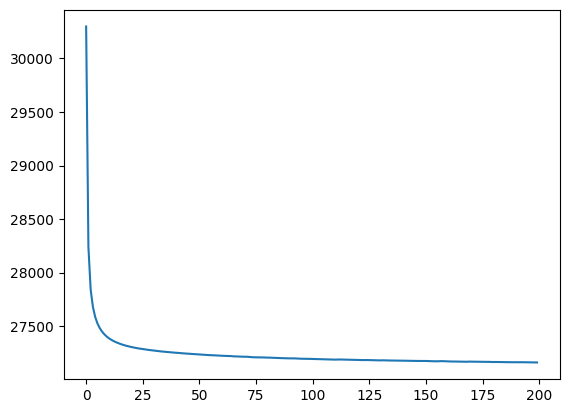

In [37]:
#plot the losses
plt.plot(losses)
plt.show()


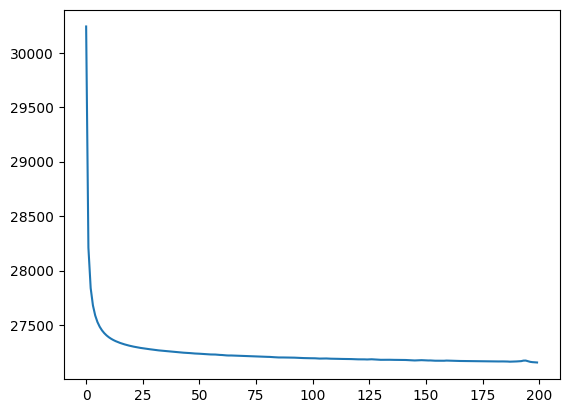

In [39]:
#plot the losses
plt.plot(losses)
plt.show()
